**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

**Kaggle Team Name:** \_\_\_\_\_

# CS5489 - Assignment 2 - Urban Sound Tagging
Due date: see Assignment 2 on Canvas

## Goal
In this assignment, the task is to annotate or tag a sound clip with descriptive (semantic) keywords.  This kind of content-based tagging system could be useful to musicians and sound engineers who want to automatically organize their sound library, or search for sound or music by keyword.

## Dataset of Urban Sounds

This dataset contains urban sounds recorded on various sensors around a busy city.  Each sound clip is annotated with semantic tags. _The data is publicly available - please do not search for it and cheat._


## Methodology
Semantic annotation is a multi-label classification problem, where each label corresponds to one sound tag and is a binary classification problem. The labels can co-occur (multiple labels can be assigned to the same sound), which makes it different from multi-class classification (where only one label can be assigned).  Sound is a temporal process, so the important thing is how to define the _feature space_ for representing the sound, before learning the binary classifiers. You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space for sound annotation.  You are free to use methods that were not introduced in class, as long as you present the details in the report.  You can also consider the co-occurence of the labels to help with the multi-label classification.


## Evaluation of Tagging

For evaluation, you will predict the presence/absence of tags for each test sound. The evaluation metric is "Mean column-wise AUC".  AUC is the area under the ROC curve, which plots FPR vs TPR.  "Mean column-wise" computes the average of the AUCs for the tags.  To compute AUC, you will need to predict the score of each label (e.g., decision function value, probability, etc.) rather than the label.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas. You must submit your Kaggle account name to the "Kaggle Username" assignment on Canvas 1 week before the Assignment 2 deadline. This is to prevent students from creating multiple Kaggle accounts to gain unfair advantage.

**Note:** You can only submit 2 times per day to Kaggle!


## What to hand in
You need to turn in the following things:

1. This ipynb file `Assignment2.ipynb` with your source code and documentation.  _**You should write about all the various attempts that you make to find a good solution.**_ You may also submit python scripts as source code, but your documentation must be in the ipynb file.
2. Your final csv submission file to Kaggle.
3. The ipynb file `Assignment2-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**
4. Your Kaggle username (submitted to the "Kaggle Username" assignment on Canvas 1 week before the Assignment 2 deadline)

Files should be uploaded to Assignment 2 on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 45% - Results using various feature representations, dimensionality reduction methods, classification methods, etc.
- 30% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 5% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

**Note: This is an individual assignment. Every student must turn in their own work!**
<hr>

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display
import os.path

In [2]:
def showAudio(info):
    myfile = 'soundwav/' + info['fname'] + '.wav'
    if os.path.exists(myfile):
        display(Audio(myfile))
    else:
        print("*** wav file " + myfile + " could not be found ***")

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training and test data are stored in various pickle files. Here we assume the data is stored in the `musicdata` directory. The below code will load the data, including tags and extracted features.

In [3]:
train_tags  = load_pickle('sounddata/train_tags.pickle3')
train_mfccs = load_pickle('sounddata/train_mfccs.pickle3')
train_mels  = load_pickle('sounddata/train_mels.pickle3')
train_info  = load_pickle('sounddata/train_info.pickle3')

test_mfccs = load_pickle('sounddata/test_mfccs.pickle3')
test_mels  = load_pickle('sounddata/test_mels.pickle3')
test_info  = load_pickle('sounddata/test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set.
- `train_mels` - the Mel-frequency spectrogram for each sound in the training set. Mel-frequency is a logarithmically-transformed frequency with better perceptual distance.  More details [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8).
- `train_mfccs` -  MFCCs (Mel-frequency cepstrum coefficients) are dimensionality-reduced version of the Mel-frequency spectrogram. Specifically, the log is applied to the magnitudes, and then a Discrete Cosine Transform is applied at each time. 
- `train_tags` - the descriptive tags for each sound in the training set.
- `test_info` - info about each sound in the test set.
- `test_mels` - the Mel Spectrogram for each sound in the test.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the one sample in the training set, as well as the tags and other info. To play the audio, we assume the wav files are available in the `soundwav` directory.

In [4]:
ii = 160
showAudio(train_info[ii])
print("tags:", train_tags[ii])
print("info:", train_info[ii])

tags: ['1-1_small-sounding-engine_presence', '1_engine_presence', '7_human-voice_presence', '7-1_person-or-small-group-talking_presence']
info: {'id': 'r73087a8', 'fname': 'r73087a8', 'split': 'train', 'counts': {'1-1_small-sounding-engine_presence': 0.3333333333333333, '1_engine_presence': 0.3333333333333333, '7_human-voice_presence': 0.6666666666666666, '7-1_person-or-small-group-talking_presence': 0.6666666666666666}, 'tags': ['1-1_small-sounding-engine_presence', '1_engine_presence', '7_human-voice_presence', '7-1_person-or-small-group-talking_presence']}


The `info` dictionary contains some additional information. Each sound is annotated by multiple people, and the `counts` field has the percentage of people who annotated that the sound was present.  The `tags` were generated from these counts, where a tag is present if at least one person annotated it in the clip (i.e., count>0).  

## Tags

Here are the tags:

In [5]:
alltagnames = unique(concatenate(train_tags))
for a in alltagnames:
    print(a)
print(f"number of tag:{alltagnames.shape}")

1-1_small-sounding-engine_presence
1-2_medium-sounding-engine_presence
1-3_large-sounding-engine_presence
1-X_engine-of-uncertain-size_presence
1_engine_presence
2-1_rock-drill_presence
2-2_jackhammer_presence
2-3_hoe-ram_presence
2-4_pile-driver_presence
2-X_other-unknown-impact-machinery_presence
2_machinery-impact_presence
3-1_non-machinery-impact_presence
3_non-machinery-impact_presence
4-1_chainsaw_presence
4-2_small-medium-rotating-saw_presence
4-3_large-rotating-saw_presence
4-X_other-unknown-powered-saw_presence
4_powered-saw_presence
5-1_car-horn_presence
5-2_car-alarm_presence
5-3_siren_presence
5-4_reverse-beeper_presence
5-X_other-unknown-alert-signal_presence
5_alert-signal_presence
6-1_stationary-music_presence
6-2_mobile-music_presence
6-3_ice-cream-truck_presence
6-X_music-from-uncertain-source_presence
6_music_presence
7-1_person-or-small-group-talking_presence
7-2_person-or-small-group-shouting_presence
7-3_large-crowd_presence
7-4_amplified-speech_presence
7-X_other-

The tags are organized hierarchically. The coarse-level has 8 tags (e.g., `1_engine_presence`), and there are fine-level tags associated with each coarse-level (e.g., `1-1_small-sounding-engine_presence`). 

The fine-level tags preceded by an `X` code (e.g., `1-X_engine-of-uncertain-size_presence`) indicate that the annotator could identiy the course-level tag, but not the fine-level tag due to uncertainty or because there was no appropriate fine-level tag. 

## Audio representation
Here is the Mel-frequency spectrogram, which shows the frequency content over time. The spectrogram is stored in an `B x T` matrix, where `B` is the number of bins, and `T` is the temporal length.  The left plot shows the original Mel spectrogram (with time increasing to the right).  The right plot shows the log magnitude, which can better visualize the differences.  Here we use `B=128` Mel-bins.

(431, 128)


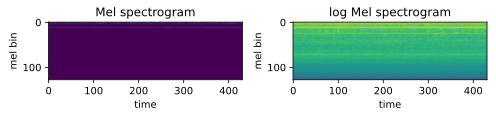

In [6]:
print(train_mels[ii].shape)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.imshow(train_mels[ii].T)
plt.xlabel('time')
plt.ylabel('mel bin')
plt.title('Mel spectrogram')
plt.subplot(1,2,2)
plt.imshow(log(train_mels[ii].T))
plt.xlabel('time')
plt.ylabel('mel bin')
plt.title('log Mel spectrogram')
plt.tight_layout()

MFCCs are a dimensionality-reduced version of the Mel-spectrogram.  To get the MFCC, the Discrete Cosine Transform (DCT) is applied to each 128-dim log-Mel bin vector.  Here we use 20-dimension DCT, so the 128-dim vector is convereted to **20-dim** in each time step.  The left plot shows the MFCCs as an image, while the right plots the individual dimensions over time.

(431, 20)


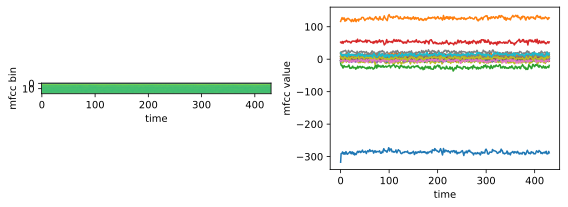

In [7]:
print(train_mfccs[ii].shape) # no.160 time-freq

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(train_mfccs[ii].T)
plt.xlabel('time')
plt.ylabel('mfcc bin')
plt.subplot(1,2,2)
plt.plot(train_mfccs[ii]);
plt.xlabel('time')
plt.ylabel('mfcc value');
plt.tight_layout()

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [8]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs: # loop audio audio
        tmp = m[1:] - m[0:-1] # subtract the previous one -> get variation over the time (assume time 0 is 0)
        dm = hstack((m[0:-1], tmp)) #first 20 is original freq value || 21 is variation for next 
        dmfccs.append(dm)
    return dmfccs

In [9]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [10]:
print(train_dmfccs[0][0])
print(f"audio Tracks :{len(train_mfccs)} ,feature engineer time: {len(train_mfccs[0])} ,frequeny dim : {len(train_mfccs[0][0])}")
print(f"audio Tracks :{len(train_dmfccs)} ,feature engineer time: {len(train_dmfccs[0])} ,frequeny dim : {len(train_dmfccs[0][0])}") #give up time 431 

[-3.9940036e+02  1.1970552e+02  6.3496532e+00  2.8409241e+01
  1.1199963e+01  2.2850021e+01  6.7305946e+00  1.7639708e+01
  9.6861963e+00  1.8253334e+01  4.6003561e+00  8.9466000e+00
  3.1585486e+00  9.6381454e+00  4.7910156e+00  8.3770227e+00
 -4.2424631e-01  6.5442104e+00 -2.1761637e+00  5.0548229e+00
 -1.8527527e+01  1.1126205e+01  3.6059217e+00  4.7051773e+00
  1.2084179e+00  4.3226852e+00  3.6049900e+00  4.1416931e-01
 -3.7175179e-01  6.0234070e-01 -3.4946401e+00 -3.2953367e+00
  5.2157135e+00  2.9840946e-01  3.7735224e-01 -4.4158492e+00
 -4.8086677e+00 -7.5314522e-02 -9.6405816e-01  2.8868618e+00]
audio Tracks :2794 ,feature engineer time: 431 ,frequeny dim : 20
audio Tracks :2794 ,feature engineer time: 430 ,frequeny dim : 40


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and **map each MFCC to one of the words**.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [11]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(1201407, 40)


In [12]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::100])  # subsample by 10 to make it faster
km.cluster_centers_
print(f"number of cluster {km.cluster_centers_.shape}")

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


number of cluster (100, 40)


Now transform the data into BOW.

In [13]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0] #100
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)): # loop tracks
        w = model.predict(mfccs[i]) # predict track class 
        bw = bincount(w, minlength=numwords) # count num wthin first 100
        bows[i,:] = bw # append the count for 2794
    return bows

In [14]:
# audio Tracks :2794 ,feature engineer time: 430 ,frequeny dim : 40
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

print(f"shape = {train_bow.shape}")
print(f"shape = {test_bow.shape}")

shape = (2794, 100)
shape = (274, 100)


# Tag pre-processing

Next, we extract all the tags from the data, and get a unique list of tags.

In [15]:
alltagnames, alltagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(alltagnames, alltagnames_counts):
    print("{}: {}".format(a, b))

1-1_small-sounding-engine_presence: 193
1-2_medium-sounding-engine_presence: 616
1-3_large-sounding-engine_presence: 775
1-X_engine-of-uncertain-size_presence: 307
1_engine_presence: 1492
2-1_rock-drill_presence: 264
2-2_jackhammer_presence: 179
2-3_hoe-ram_presence: 79
2-4_pile-driver_presence: 55
2-X_other-unknown-impact-machinery_presence: 255
2_machinery-impact_presence: 650
3-1_non-machinery-impact_presence: 349
3_non-machinery-impact_presence: 349
4-1_chainsaw_presence: 101
4-2_small-medium-rotating-saw_presence: 100
4-3_large-rotating-saw_presence: 96
4-X_other-unknown-powered-saw_presence: 79
4_powered-saw_presence: 267
5-1_car-horn_presence: 286
5-2_car-alarm_presence: 28
5-3_siren_presence: 174
5-4_reverse-beeper_presence: 175
5-X_other-unknown-alert-signal_presence: 70
5_alert-signal_presence: 635
6-1_stationary-music_presence: 84
6-2_mobile-music_presence: 26
6-3_ice-cream-truck_presence: 6
6-X_music-from-uncertain-source_presence: 73
6_music_presence: 150
7-1_person-or-sma

We will remove some tags that are not sufficiently present in the test set. 

In [16]:
blacklist = ['2-3_hoe-ram_presence', '2-4_pile-driver_presence', '5-2_car-alarm_presence', '5-X_other-unknown-alert-signal_presence', '6-3_ice-cream-truck_presence', '7-3_large-crowd_presence', '7-X_other-unknown-human-voice_presence']
tagnames = [t for t in alltagnames if t not in blacklist]
print(tagnames)

['1-1_small-sounding-engine_presence', '1-2_medium-sounding-engine_presence', '1-3_large-sounding-engine_presence', '1-X_engine-of-uncertain-size_presence', '1_engine_presence', '2-1_rock-drill_presence', '2-2_jackhammer_presence', '2-X_other-unknown-impact-machinery_presence', '2_machinery-impact_presence', '3-1_non-machinery-impact_presence', '3_non-machinery-impact_presence', '4-1_chainsaw_presence', '4-2_small-medium-rotating-saw_presence', '4-3_large-rotating-saw_presence', '4-X_other-unknown-powered-saw_presence', '4_powered-saw_presence', '5-1_car-horn_presence', '5-3_siren_presence', '5-4_reverse-beeper_presence', '5_alert-signal_presence', '6-1_stationary-music_presence', '6-2_mobile-music_presence', '6-X_music-from-uncertain-source_presence', '6_music_presence', '7-1_person-or-small-group-talking_presence', '7-2_person-or-small-group-shouting_presence', '7-4_amplified-speech_presence', '7_human-voice_presence', '8-1_dog-barking-whining_presence', '8_dog_presence']


Now we convert the list of tags for each sound into binary attributes.

In [17]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [18]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes = tags2class(train_tags, tagnames)
print(train_classes.shape)
print(train_classes[0:3])

(2794, 30)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [19]:
# double check we did this correctly...
# it should be the same as the tag counts above
sum(train_classes,axis=0)

array([ 193.,  616.,  775.,  307., 1492.,  264.,  179.,  255.,  650.,
        349.,  349.,  101.,  100.,   96.,   79.,  267.,  286.,  174.,
        175.,  635.,   84.,   26.,   73.,  150.,  886.,  113.,   11.,
        977.,  157.,  157.])

## Baseline experiments

Next, we will run a baseline experiment doing semantic tagging with bag-of-audio words.

Apply TF-IDF to the count vectors.

In [20]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

Now learn a logisic regression classifier for each tag.

In [21]:
tagmodels = {}
for i,t in enumerate(tagnames): #loop tag name
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel() # get the corrspoend class col , flatten without copy
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr #store tag classifer

training 0 - 1-1_small-sounding-engine_presence


training 1 - 1-2_medium-sounding-engine_presence
training 2 - 1-3_large-sounding-engine_presence
training 3 - 1-X_engine-of-uncertain-size_presence
training 4 - 1_engine_presence
training 5 - 2-1_rock-drill_presence
training 6 - 2-2_jackhammer_presence
training 7 - 2-X_other-unknown-impact-machinery_presence
training 8 - 2_machinery-impact_presence
training 9 - 3-1_non-machinery-impact_presence
training 10 - 3_non-machinery-impact_presence
training 11 - 4-1_chainsaw_presence
training 12 - 4-2_small-medium-rotating-saw_presence
training 13 - 4-3_large-rotating-saw_presence
training 14 - 4-X_other-unknown-powered-saw_presence
training 15 - 4_powered-saw_presence
training 16 - 5-1_car-horn_presence
training 17 - 5-3_siren_presence
training 18 - 5-4_reverse-beeper_presence
training 19 - 5_alert-signal_presence
training 20 - 6-1_stationary-music_presence
training 21 - 6-2_mobile-music_presence
training 22 - 6-X_music-from-uncertain-source_presence
training 23 - 6_music_presence
training 24 

To see how we did on tagging the training set, we compute the tag scores.

In [22]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames): # do prediction for each class 
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

predicting 0 - 1-1_small-sounding-engine_presence
predicting 1 - 1-2_medium-sounding-engine_presence
predicting 2 - 1-3_large-sounding-engine_presence
predicting 3 - 1-X_engine-of-uncertain-size_presence
predicting 4 - 1_engine_presence
predicting 5 - 2-1_rock-drill_presence
predicting 6 - 2-2_jackhammer_presence
predicting 7 - 2-X_other-unknown-impact-machinery_presence
predicting 8 - 2_machinery-impact_presence
predicting 9 - 3-1_non-machinery-impact_presence
predicting 10 - 3_non-machinery-impact_presence
predicting 11 - 4-1_chainsaw_presence
predicting 12 - 4-2_small-medium-rotating-saw_presence
predicting 13 - 4-3_large-rotating-saw_presence
predicting 14 - 4-X_other-unknown-powered-saw_presence
predicting 15 - 4_powered-saw_presence
predicting 16 - 5-1_car-horn_presence
predicting 17 - 5-3_siren_presence
predicting 18 - 5-4_reverse-beeper_presence
predicting 19 - 5_alert-signal_presence
predicting 20 - 6-1_stationary-music_presence
predicting 21 - 6-2_mobile-music_presence
predic

And then plot the ROC curve using the training classes and training predicted scores.

In [23]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i]) # check columns
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.grid(True)

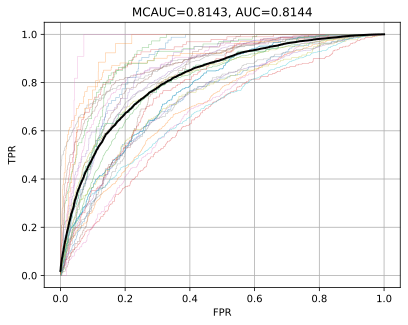

In [24]:
plot_roc(tagnames, train_classes, train_predscore) #test with training data

Note that AUC is the AUC of the black curve, while MCAUC is the average of the AUCs for all the color curves.

Now apply the LR classifiers to the test set to predict the score for each tag.

In [25]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - 1-1_small-sounding-engine_presence
predicting 1 - 1-2_medium-sounding-engine_presence
predicting 2 - 1-3_large-sounding-engine_presence
predicting 3 - 1-X_engine-of-uncertain-size_presence
predicting 4 - 1_engine_presence
predicting 5 - 2-1_rock-drill_presence
predicting 6 - 2-2_jackhammer_presence
predicting 7 - 2-X_other-unknown-impact-machinery_presence
predicting 8 - 2_machinery-impact_presence
predicting 9 - 3-1_non-machinery-impact_presence
predicting 10 - 3_non-machinery-impact_presence
predicting 11 - 4-1_chainsaw_presence
predicting 12 - 4-2_small-medium-rotating-saw_presence
predicting 13 - 4-3_large-rotating-saw_presence
predicting 14 - 4-X_other-unknown-powered-saw_presence
predicting 15 - 4_powered-saw_presence
predicting 16 - 5-1_car-horn_presence
predicting 17 - 5-3_siren_presence
predicting 18 - 5-4_reverse-beeper_presence
predicting 19 - 5_alert-signal_presence
predicting 20 - 6-1_stationary-music_presence
predicting 21 - 6-2_mobile-music_presence
predic

We have the scores, now lets look at the predicted tags.

In [26]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

We need to convert the score into a binary class label using a threshold (usually 0).

In [27]:
# convert score into binary class 0 or 1.  
test_predclass = test_predscore>0
print(test_predclass[0])
# convert to tags
test_predtags = class2tags(test_predclass, tagnames)

[ True False False  True False False  True False  True False False  True
  True  True  True  True False False False False False False False False
 False False False False False False]


Here is an example of the predicted labels and the label scores. Positive label scores indicate presence of the sound.

1-1_small-sounding-engine_presence 1-X_engine-of-uncertain-size_presence 2-2_jackhammer_presence 2_machinery-impact_presence 4-1_chainsaw_presence 4-2_small-medium-rotating-saw_presence 4-3_large-rotating-saw_presence 4-X_other-unknown-powered-saw_presence 4_powered-saw_presence


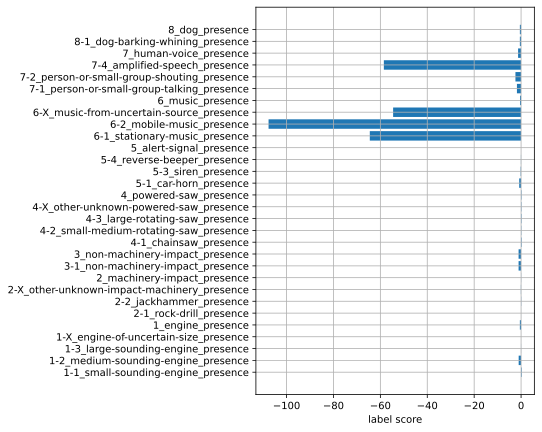

In [28]:
ii = 0
# view tags and audio
print(test_predtags[ii])
showAudio(test_info[ii])

# view the scores
plt.figure(figsize=(5,7))
plt.barh(tagnames, test_predscore[ii]);
plt.xlabel('label score')
plt.grid(True)

Now write the tag scores for the test set for submission to Kaggle. We need to upload the **tag scores** (not the class predictions) so that Kaggle can generate the ROC curves and calculate AUC.

In [29]:
import csv

def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [30]:
write_csv_kaggle_tags("sound_bow_baseline.csv", tagnames, test_predscore)

## YOUR CODE and DOCUMENTATION HERE

**use what to vecotorize the auido**

**change to random forest**

training 0 - 1-1_small-sounding-engine_presence
training 1 - 1-2_medium-sounding-engine_presence
training 2 - 1-3_large-sounding-engine_presence
training 3 - 1-X_engine-of-uncertain-size_presence
training 4 - 1_engine_presence
training 5 - 2-1_rock-drill_presence
training 6 - 2-2_jackhammer_presence
training 7 - 2-X_other-unknown-impact-machinery_presence
training 8 - 2_machinery-impact_presence
training 9 - 3-1_non-machinery-impact_presence
training 10 - 3_non-machinery-impact_presence
training 11 - 4-1_chainsaw_presence
training 12 - 4-2_small-medium-rotating-saw_presence
training 13 - 4-3_large-rotating-saw_presence
training 14 - 4-X_other-unknown-powered-saw_presence
training 15 - 4_powered-saw_presence
training 16 - 5-1_car-horn_presence
training 17 - 5-3_siren_presence
training 18 - 5-4_reverse-beeper_presence
training 19 - 5_alert-signal_presence
training 20 - 6-1_stationary-music_presence
training 21 - 6-2_mobile-music_presence
training 22 - 6-X_music-from-uncertain-source_pres

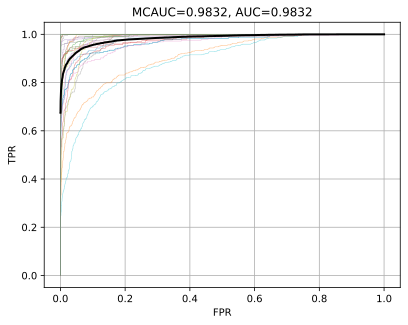

In [44]:
from sklearn import ensemble,model_selection
tag_rf_models = {}
for i,t in enumerate(tagnames): #loop tag name
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel() # get the corrspoend class col , flatten without copy
    paramgrid={"n_estimators":array([77,99]),
    "max_depth":[9,17],

    }
    rf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(random_state=7),paramgrid,cv=5,n_jobs=-1)
    rf.fit(train_Xtf, myY)
    rf = rf.best_estimator_
    tag_rf_models[t] = rf #store tag classifer

#prediction
# train
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames): # do prediction for each class 
    print('predicting {} - {}'.format(i, t))
    index = where(tag_rf_models[t].classes_==1)[0][0]
    tmp = tag_rf_models[t].predict_proba(train_Xtf)[:,index]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore) #test with training data


# test 
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    index = where(tag_rf_models[t].classes_==1)[0][0]
    tmp = tag_rf_models[t].predict_proba(test_Xtf)[:,index]
    test_predscore[:,i] = tmp

# write result 
write_csv_kaggle_tags("output/sound_TFIDF_randomforest.csv", tagnames, test_predscore)

In [40]:
print(rf.classes_)
print(where(rf.classes_==1)[0][0])

[0. 1.]
1


**TFIDF + XGboost**

training 0 - 1-1_small-sounding-engine_presence
training 1 - 1-2_medium-sounding-engine_presence
training 2 - 1-3_large-sounding-engine_presence
training 3 - 1-X_engine-of-uncertain-size_presence
training 4 - 1_engine_presence
training 5 - 2-1_rock-drill_presence
training 6 - 2-2_jackhammer_presence
training 7 - 2-X_other-unknown-impact-machinery_presence
training 8 - 2_machinery-impact_presence
training 9 - 3-1_non-machinery-impact_presence
training 10 - 3_non-machinery-impact_presence
training 11 - 4-1_chainsaw_presence
training 12 - 4-2_small-medium-rotating-saw_presence
training 13 - 4-3_large-rotating-saw_presence
training 14 - 4-X_other-unknown-powered-saw_presence
training 15 - 4_powered-saw_presence
training 16 - 5-1_car-horn_presence
training 17 - 5-3_siren_presence
training 18 - 5-4_reverse-beeper_presence
training 19 - 5_alert-signal_presence
training 20 - 6-1_stationary-music_presence
training 21 - 6-2_mobile-music_presence
training 22 - 6-X_music-from-uncertain-source_pres

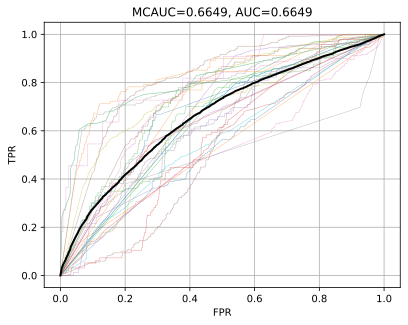

In [46]:
import xgboost as xgb
tag_xg_models ={}
for i,t in enumerate(tagnames): #loop tag name
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel() # get the corrspoend class col , flatten without copy
    paramgrid={
        "n_estimators":array([800]),
        "max_depth":[800],
        'objective': ['binary:logistic'],
        'learning_rate':[0.01],
        "lambda":[0.1],
        "eval_metric":['auc'],
    }
    xg = model_selection.GridSearchCV(xgb.XGBClassifier(device="cuda",random_state=4),paramgrid,cv=5,n_jobs=-1)
    xg.fit(train_Xtf, myY)
    xg = xg.best_estimator_
    tag_xg_models[t] = xg #store tag classifer

#prediction
# train
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames): # do prediction for each class 
    print('predicting {} - {}'.format(i, t))
    index = where(tag_xg_models[t].classes_==1)[0][0]
    tmp = tag_xg_models[t].predict_proba(train_Xtf)[:,index]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore) #test with training data


# test 
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    index = where(tag_xg_models[t].classes_==1)[0][0]
    tmp = tag_xg_models[t].predict_proba(test_Xtf)[:,index]
    test_predscore[:,i] = tmp

# write result 
write_csv_kaggle_tags("output/sound_TFIDF_XGBoost.csv", tagnames, test_predscore)

[0 1]


**TFIDF+ DeepLearning**

**PCA**